# Data Analyzer

- DataAnalyzer Klasse testen, möglichst so wie sie am Ende aussieht
- Idee: task "analyze" soll später als thread aufgerufen werden können
- laden der Daten soll von einem externen Objekt möglich sein 


In [233]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import label, find_objects, median_filter
import lmfit

In [234]:
class ImageAquirer:
    def __init__(self,filepath):
        self.file_path = filepath
        self.index = 1

    def load_im (self):
        filename = self.file_path + str(self.index) + 'test.npy'
        with open(filename, 'rb') as f:
            ar = np.load(f)
        self.index += 1
        ar = ar.reshape(1456, 1936)
        return ar

In [235]:
class Image:
    def __init__(self, image_aquirer):
        self.ia = image_aquirer

        self.data = None
        self.edge = None
        self.update()

    def load_data(self):
        self.data = self.ia.load_im()
    
    def update(self):
        self.load_data()
        self.edge = self.data.shape
        
    def show(self):
        print(self.edge)
        plt.imshow(self.data, cmap='gray')
        plt.show()

In [236]:
class Roi:
    def __init__(self, x_start,x_stop,y_start,y_stop, image):
        self.x_start = x_start
        self.x_stop = x_stop
        self.y_start = y_start
        self.y_stop = y_stop

        self.data = None
        self.edge = None
        self.update(image)

    def load_data(self, image):
        self.data = image.data[(slice(self.y_start, self.y_stop, None), 
                                slice(self.x_start, self.x_stop, None))]
    
    def update(self, image):
        self.load_data(image)
        self.edge = self.data.shape
    
    def change_position_by_user(self,x_start,x_stop,y_start,y_stop):
        pass

    def y_coordinate_in_image(self, y):
        return y + self.y_start
    
    def x_coordinate_in_image(self, x):
        return x + self.x_start

    def show(self):
        print(self.edge)
        plt.imshow(self.data, cmap='gray')
        plt.show()


In [237]:
class FitArea:
    def __init__(self, roi, image, factor, threshold, median=True):
        self.factor = factor
        self.threshold = threshold
        self.median = median

        self.data = None
        self.edge = None
        self.update(roi, image)
    
    def load_data(self, roi, image):
        #median filter
        data = roi.data
        if self.median:
            data = median_filter(data, size=2)

        #threshold filter 
        data = data > self.threshold
        
        #labeln
        data, num_label = label(data)
            #TO DO: check num_label with error

        #fit data frame 
        frame = find_objects(data)
            #TO DO: check if only one object (sonst geht frame[0] nicht)
        y_start, y_stop, x_start, x_stop = frame[0][0].start, frame[0][0].stop, frame[0][1].start, frame[0][1].stop
        dif_x, dif_y = self.calculate_expantion (self.factor, x_start, x_stop, y_start, y_stop)
        frame = self.expand(dif_x, dif_y, 
                            roi.x_coordinate_in_image(x_start), roi.x_coordinate_in_image(x_stop), 
                            roi.y_coordinate_in_image(y_start), roi.y_coordinate_in_image(y_stop), 
                            image.edge[0], image.edge[1])
            #TO DO: check if max werte stimmen
        
        #slice image for
        self.data = image.data[frame]
    
    def calculate_expantion (self, factor, x_start, x_stop, y_start, y_stop):
        dif_x = int (abs (x_stop - x_start) * factor)
        dif_y = int (abs (y_stop - y_start) * factor)
        return dif_x, dif_y
    
    def expand(self, add_x, add_y, x_start, x_stop, y_start, y_stop, max_x, max_y):
        y_a_neu, y_e_neu = self.expand_partly(add_y,y_start, y_stop, max_y)
        x_a_neu, x_e_neu = self.expand_partly(add_x,x_start, x_stop, max_x)
        return (slice(y_a_neu,y_e_neu, None), slice(x_a_neu, x_e_neu, None))
    
    def expand_partly(self, expantion, start, stop, max, min=0):
        start_new = start - expantion
        stop_new = stop + expantion
        if start_new < min:
            start_new = min
        if stop_new > max:
            stop_new = max
        return start_new, stop_new
    
    def update(self, roi, image):
        self.load_data(roi, image)
        self.edge = self.data.shape

    def change_factor_by_user():
        pass

    def change_threshold_by_user():
        pass

    def change_median_usage_by_user():
        pass

    def show(self):
            print(self.edge)
            plt.imshow(self.data, cmap='gray')
            plt.show()    


In [238]:
class Gaussmodel:
    def __init__(self, fit_area):
        self.z_values_in = fit_area.data.flatten()
        edge_x = fit_area.edge[1]
        edge_y = fit_area.edge[0]
            #TO DO: double check if there is some better syntax
        self.x_values = np.repeat(np.array([range(0,edge_x)]), edge_y, axis=0).flatten()
        self.y_values = np.repeat(np.array([range(edge_y-1, -1, -1)]).reshape(edge_y,1), edge_x, axis=1).flatten()

        self.gauss_model = lmfit.models.Gaussian2dModel()
        self.params = self.gauss_model.guess(self.z_values_in, self.x_values,self.y_values)
        
        self.result = self.gauss_model.fit(self.z_values_in, x=self.x_values, y=self.y_values, params=self.params)
        self.params = self.result.params
        #lmfit.report_fit(self.result)
    
    def update(self, fit_area):
           self.z_values_in = fit_area.data.flatten()
           edge_x = fit_area.edge[0]
           edge_y = fit_area.edge[1]
                #TO DO: double check if there is some better syntax
                #TO DO: check if map values between 0 to 1 is making any difference 
           self.x_values = np.repeat(np.array([range(0,edge_x)]), edge_y, axis=0).flatten()
           self.y_values = np.repeat(np.array([range(edge_y-1, -1, -1)]).reshape(edge_y,1), edge_x, axis=1).flatten()
           
           self.result = self.gauss_model.fit(self.z_values_in, x=self.x_values, y=self.y_values, params=self.params)
           self.params = self.result.params
           #lmfit.report_fit(self.result)

    def get_result(self):
        result = []
        for name, param in self.params.items():
                #TO DO: check if data structur is useful that way
            result.append([name, param.value])
        return result
        
    def show(self):
        fig = plt.figure(figsize=plt.figaspect(0.5))

        #old data
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.set_title("data in")
        ax.scatter(self.x_values, self.y_values, self.z_values_in, c=self.z_values_in, cmap='viridis', linewidth=0.5)

        #fitted data
        z_values_new = self.gauss_model.func(self.x_values, self.y_values, **self.result.best_values)
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.set_title("data fitted")
        ax.scatter(self.x_values, self.y_values, z_values_new, c=z_values_new, cmap='viridis', linewidth=0.5)

        plt.show()

        #fit report
        print("fit")
        lmfit.report_fit(self.result)


## Test

Schritt für Schritt testen Subklassen test

(1456, 1936)


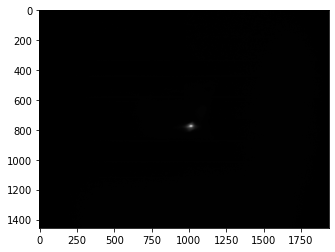

In [239]:
ia = ImageAquirer('D:\\HZB\\Camera_Data\\test_roi\\')
im = Image(ia)
im.show()

(150, 200)


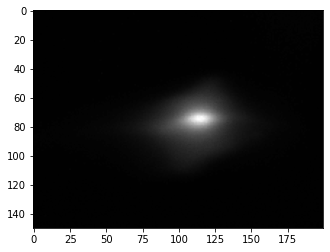

In [240]:
roi = Roi(900, 1100, 700, 850, im)
roi.show()


(65, 120)


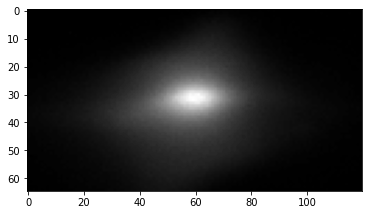

In [241]:
fit_area = FitArea(roi, im, 2, 70)
fit_area.show()

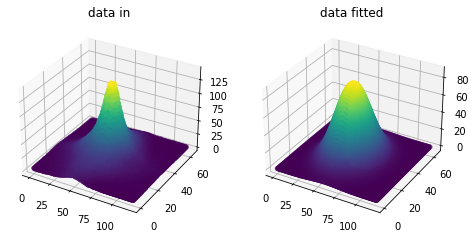

fit
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 7800
    # variables        = 5
    chi-square         = 351271.983
    reduced chi-square = 45.0637566
    Akaike info crit   = 29708.0091
    Bayesian info crit = 29742.8185
[[Variables]]
    amplitude:  104101.252 +/- 468.327332 (0.45%) (init = 29194.67)
    centerx:    57.8887923 +/- 0.07519227 (0.13%) (init = 59)
    centery:    31.5641061 +/- 0.05184051 (0.16%) (init = 32)
    sigmax:     16.7395288 +/- 0.07519807 (0.45%) (init = 19.83333)
    sigmay:     11.5341671 +/- 0.05206214 (0.45%) (init = 10.66667)
    fwhmx:      39.4185772 +/- 0.17707792 (0.45%) == '2.3548200*sigmax'
    fwhmy:      27.1608873 +/- 0.12259698 (0.45%) == '2.3548200*sigmay'
    height:     846.927734 +/- 3.80791345 (0.45%) == '1.5707963*amplitude/(max(1e-15, sigmax)*max(1e-15, sigmay))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) =  0.502
    C(amplitude, sigmax) 

In [242]:
g_model = Gaussmodel(fit_area)
g_model.show()

zu einer Klasse zusammenführen 

In [243]:
class DataAnalyzer:
    def __init__(self):
        self.ia = ImageAquirer('D:\\HZB\\Camera_Data\\test_roi\\')
        self.im = Image(self.ia)
        self.roi = Roi(900, 1100, 700, 850,self.im)
        self.fit_area = FitArea(self.roi, self.im, 2, 70)
        self.g_model = Gaussmodel(self.fit_area)
        self.result = g_model.get_result()

    def analyze(self):
        self.im.update()
        self.roi.update(self.im)
        self.fit_area.update(self.roi,self.im)
        self.g_model.update(self.fit_area)
        self.result = g_model.get_result()
    
    def show(self):
        print("im")
        self.im.show()
        print("roi")
        self.roi.show()
        print("fit_area")
        self.fit_area.show()
        print("model")
        self.g_model.show()

im
(1456, 1936)


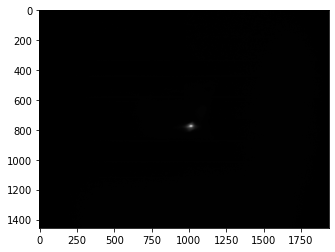

roi
(150, 200)


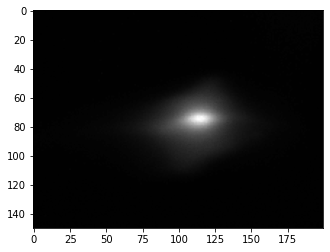

fit_area
(65, 120)


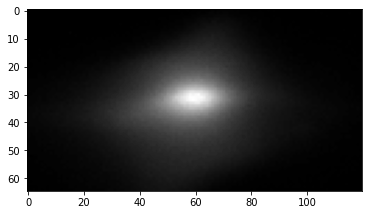

model


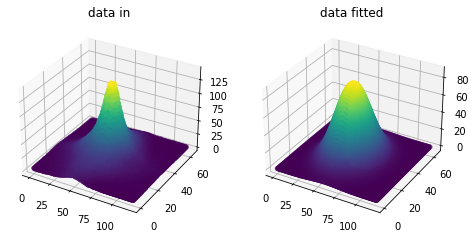

fit
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 7800
    # variables        = 5
    chi-square         = 351271.983
    reduced chi-square = 45.0637566
    Akaike info crit   = 29708.0091
    Bayesian info crit = 29742.8185
[[Variables]]
    amplitude:  104101.252 +/- 468.327332 (0.45%) (init = 29194.67)
    centerx:    57.8887923 +/- 0.07519227 (0.13%) (init = 59)
    centery:    31.5641061 +/- 0.05184051 (0.16%) (init = 32)
    sigmax:     16.7395288 +/- 0.07519807 (0.45%) (init = 19.83333)
    sigmay:     11.5341671 +/- 0.05206214 (0.45%) (init = 10.66667)
    fwhmx:      39.4185772 +/- 0.17707792 (0.45%) == '2.3548200*sigmax'
    fwhmy:      27.1608873 +/- 0.12259698 (0.45%) == '2.3548200*sigmay'
    height:     846.927734 +/- 3.80791345 (0.45%) == '1.5707963*amplitude/(max(1e-15, sigmax)*max(1e-15, sigmay))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) =  0.502
    C(amplitude, sigmax) 

In [244]:
data_analyzer = DataAnalyzer()
data_analyzer.show()

Testing roi

(65, 120)


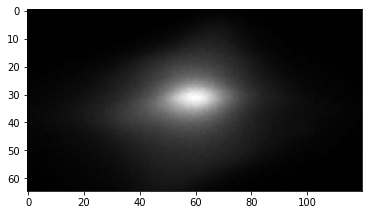

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(65, 120)


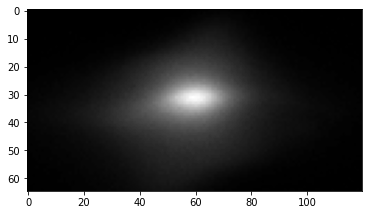

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(70, 120)


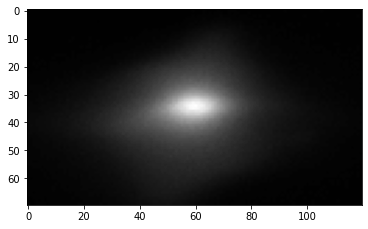

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(65, 120)


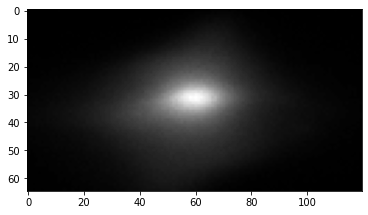

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(65, 120)


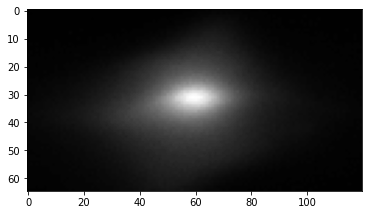

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(70, 120)


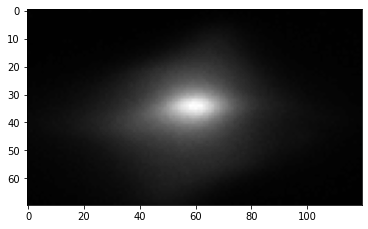

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(70, 120)


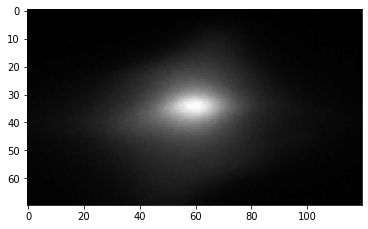

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(65, 120)


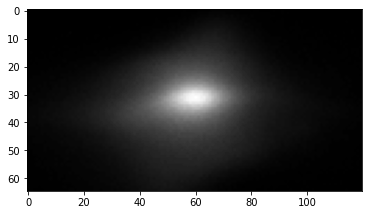

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(65, 120)


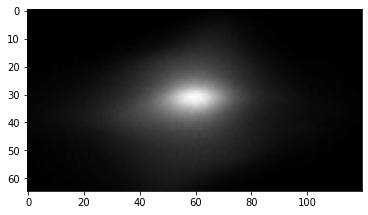

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]
(65, 120)


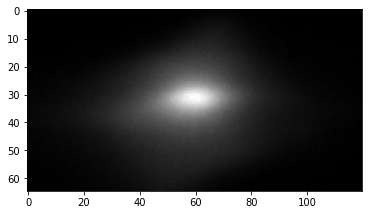

[['amplitude', 104101.25203307444], ['centerx', 57.888792346775084], ['centery', 31.564106128775517], ['sigmax', 16.739528805467177], ['sigmay', 11.534167087644882], ['fwhmx', 39.41857722169022], ['fwhmy', 27.16088734132792], ['height', 846.9277343853885]]


In [245]:
for i in range (0,10):
    data_analyzer.analyze()
    data_analyzer.fit_area.show()
    print(data_analyzer.result)

## Ergebnis

- bei diesen Daten, Alg. findet fit_area in roi
- Klassenkonzept so ganz gut umsetzbar -> Image Aquirer und Model auch als Interface umsetzbar und unabhängig von der DataAnalyzer Klasse (nur image_data übergeben nicht Objekt)


- Problematiken die entstehen könnten bei richtigen Daten: 
- - Daten hier nicht besonders Gaussförmig, Model mit besseren Daten überprüfen
- - Daten gequetscher Gaus, das Model guckt nach ungequetschem Gaus
- - die ersten mls Daten sind anders gemappt, da funktioneniern Schwellwert bzw. median nicht mehr um nur ein Objekt zu finden


- TO DO: 
- -  wie wird reagiert wenn zu viel oder wenig objecte gefunden bzw. belabelt werden 
- - Wie werden welche Warnungen gesendet
- - was passiert wenn sich fit_area aus roi oder aus Bild bewegt?
- - beim Fit: Result ändert sich oder nicht?, mappen der Koordinaten sinnvoll?,  gequetschter Gaus?, Koordinaten einfacher erzeugbar?

